In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

def remove_sil(path_in, path_out, format="wav"):
    sound = AudioSegment.from_file(path_in, format=format)
    non_sil_times = detect_nonsilent(sound, min_silence_len=50, silence_thresh=sound.dBFS * 1.5)
    if len(non_sil_times) > 0:
        non_sil_times_concat = [non_sil_times[0]]
        if len(non_sil_times) > 1:
            for t in non_sil_times[1:]:
                if t[0] - non_sil_times_concat[-1][-1] < 50:
                    non_sil_times_concat[-1][-1] = t[1]
                else:
                    non_sil_times_concat.append(t)
        non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 80]
        sound[non_sil_times[0][0]: non_sil_times[-1][1]].export(path_out, format='wav')

In [8]:
# đường dẫn đến thư mục chứa các thư mục và file âm thanh cần xử lý
input_dir = "data/"

# đường dẫn đến thư mục để lưu các file đã xử lý
output_dir = "data_cuted/"

# tạo thư mục output nếu nó chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# duyệt các thư mục và file âm thanh trong thư mục input_dir
for root, dirs, files in os.walk(input_dir):
    # tạo đường dẫn đến thư mục con trong output_dir tương ứng với thư mục con trong input_dir
    output_subdir = os.path.join(output_dir, os.path.relpath(root, input_dir))
    os.makedirs(output_subdir, exist_ok=True)
    for filename in files:
        if filename.endswith(".wav"):
            path_in = os.path.join(root, filename)
            path_out = os.path.join(output_subdir, filename)
            remove_sil(path_in, path_out)

In [9]:
DATASET_PATH = 'data_cuted'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['batden' 'batdieuhoa' 'batquat' 'dongcua' 'giamtocdoquat' 'mocua'
 'tangtocdoquat' 'tatden' 'tatdieuhoa' 'tatquat']


In [10]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1000
Number of examples per label: 100
Example file tensor: tf.Tensor(b'data_cuted\\tatden\\71_NNM_08_tatden.wav', shape=(), dtype=string)


In [11]:
train_files = filenames[:800]
val_files = filenames[800: 900]
test_files = filenames[-100:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 800
Validation set size 100
Test set size 100


In [12]:
test_file = tf.io.read_file('data/batdieuhoa/42_LVA_01_batdieuhoa.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([21346, 1])

In [13]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [14]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

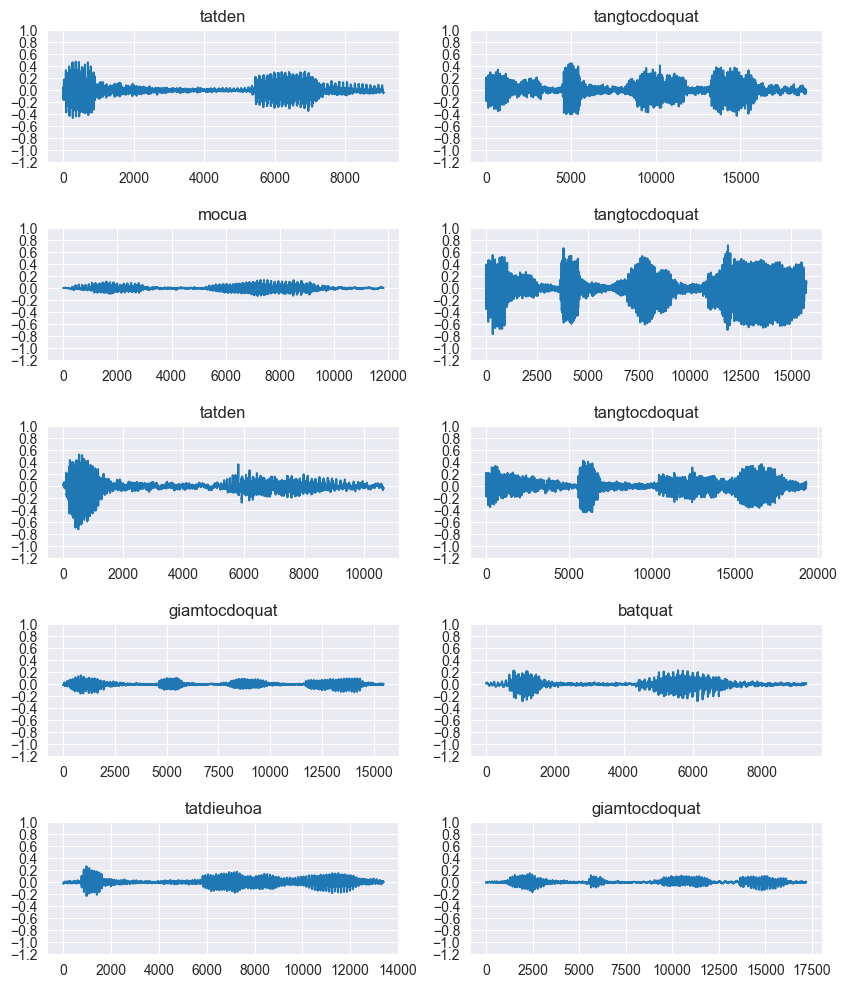

In [17]:
rows = 5
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

fig.subplots_adjust(hspace=0.5)
plt.show()


In [18]:
# def get_spectrogram(waveform):
#   # Zero-padding for an audio waveform with less than 16,000 samples.
#   input_len = 16000
#   waveform = waveform[:input_len]
#   zero_padding = tf.zeros(
#       [16000] - tf.shape(waveform),
#       dtype=tf.float32)
#   # Cast the waveform tensors' dtype to float32.
#   waveform = tf.cast(waveform, dtype=tf.float32)
#   # Concatenate the waveform with `zero_padding`, which ensures all audio
#   # clips are of the same length.
#   equal_length = tf.concat([waveform, zero_padding], 0)
#   # Convert the waveform to a spectrogram via a STFT.
#   spectrogram = tf.signal.stft(
#       equal_length, frame_length=512, frame_step=128)
#   # Obtain the magnitude of the STFT.
#   spectrogram = tf.abs(spectrogram)
#   # Add a `channels` dimension, so that the spectrogram can be used
#   # as image-like input data with convolution layers (which expect
#   # shape (`batch_size`, `height`, `width`, `channels`).
#   spectrogram = spectrogram[..., tf.newaxis]
#   return spectrogram
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 32000
  waveform = waveform[:input_len]
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  # Resize the spectrogram to a fixed size (e.g., 224x224).
  spectrogram = tf.image.resize(spectrogram, size=(240, 240))
  return spectrogram

In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: tatden
Waveform shape: (9088,)
Spectrogram shape: (240, 240, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

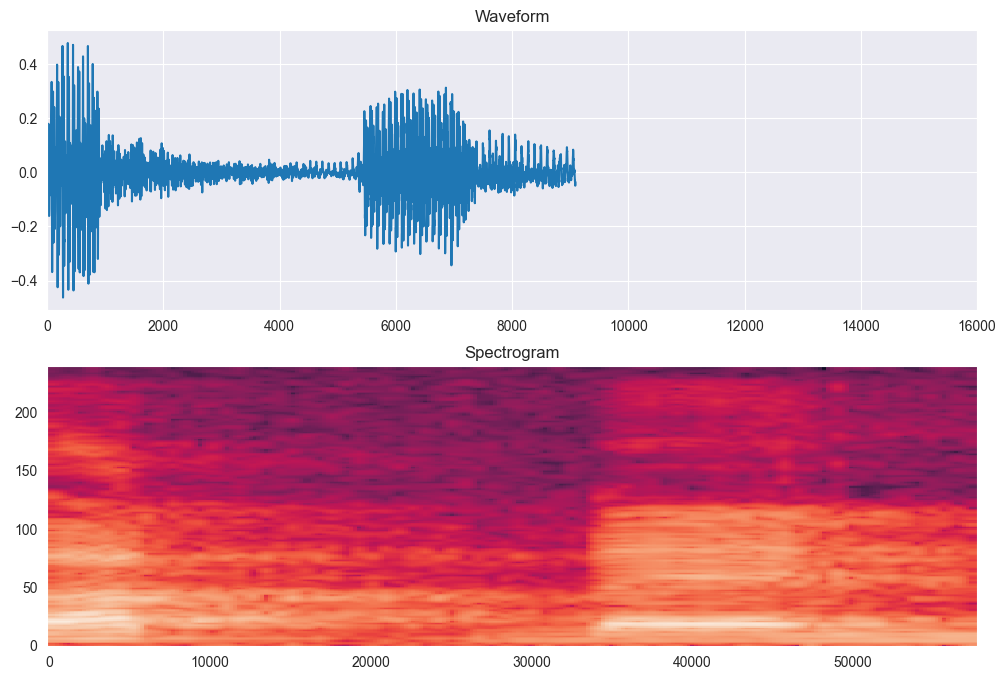

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

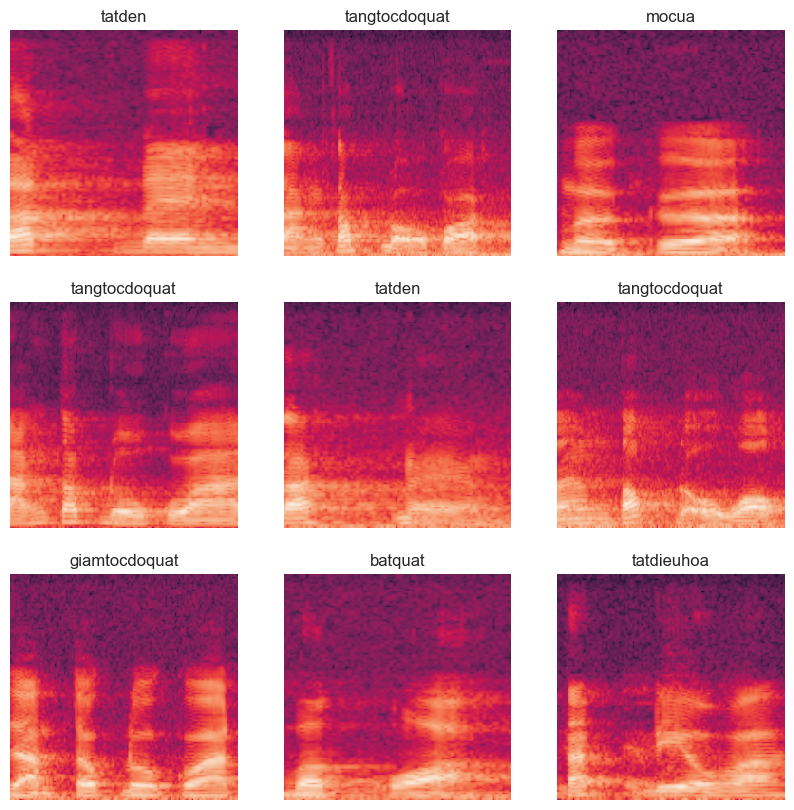

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [25]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [27]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (240, 240, 1)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
13/13 [==============================] - 3s 109ms/step - loss: 2.0137 - accuracy: 0.2850 - val_loss: 1.3107 - val_accuracy: 0.5700
Epoch 2/15
13/13 [==============================] - 1s 72ms/step - loss: 1.3969 - accuracy: 0.5113 - val_loss: 0.7827 - val_accuracy: 0.8000
Epoch 3/15
13/13 [==============================] - 1s 69ms/step - loss: 1.0273 - accuracy: 0.6488 - val_loss: 0.5247 - val_accuracy: 0.8600
Epoch 4/15
13/13 [==============================] - 1s 67ms/step - loss: 0.8608 - accuracy: 0.6988 - val_loss: 0.4375 - val_accuracy: 0.8600
Epoch 5/15
13/13 [==============================] - 1s 72ms/step - loss: 0.6838 - accuracy: 0.7475 - val_loss: 0.3823 - val_accuracy: 0.8400
Epoch 6/15
13/13 [==============================] - 1s 67ms/step - loss: 0.6207 - accuracy: 0.7713 - val_loss: 0.2860 - val_accuracy: 0.9100
Epoch 7/15
13/13 [==============================] - 1s 69ms/step - loss: 0.4909 - accuracy: 0.8325 - val_loss: 0.1973 - val_accuracy: 0.9300
Epoch 8/15
1

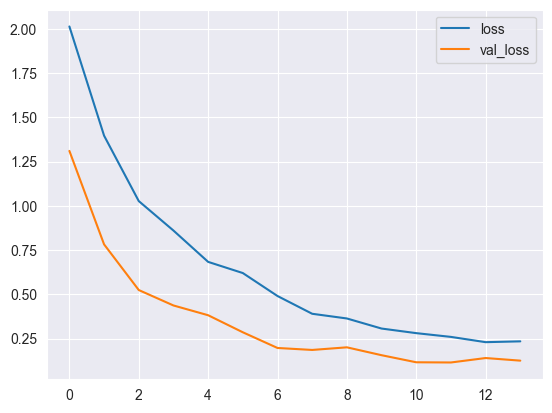

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

4/4 [==============================] - 0s 5ms/step
Test set accuracy: 95%


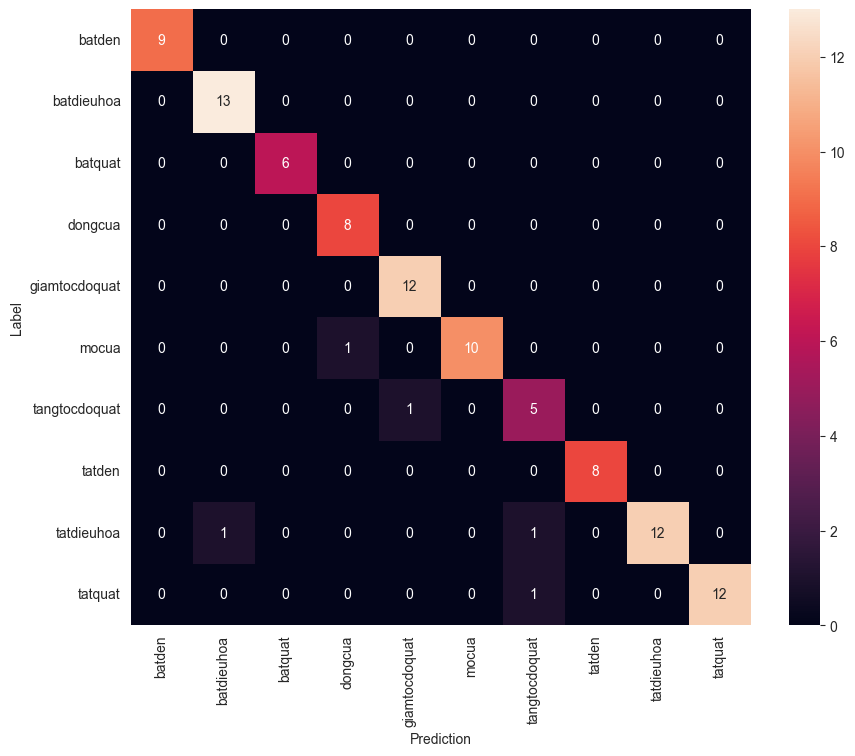

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [36]:
model.save_weights('CNNs.h5')

In [37]:
import numpy as np

def remove_silence(audio_file):
    # Mở file âm thanh và đọc các thông số
    with wave.open(audio_file, 'rb') as wav:
        frames = wav.readframes(-1)
        rate = wav.getframerate()
        channels = wav.getnchannels()
        sample_width = wav.getsampwidth()
        num_frames = wav.getnframes()

    # Chuyển đổi byte thành mảng số nguyên
    frames = np.frombuffer(frames, dtype=np.int16)

    # Tìm các mẫu âm thanh có giá trị vượt quá ngưỡng
    threshold = 500  # ngưỡng giá trị
    silence_mask = abs(frames) < threshold
    silence_starts, = np.where(np.diff(silence_mask.astype(int)) == 1)
    silence_ends, = np.where(np.diff(silence_mask.astype(int)) == -1)

    # Thêm giá trị đầu tiên và cuối cùng vào danh sách
    if silence_starts[0] > silence_ends[0]:
        silence_starts = np.concatenate([[0], silence_starts])
    if silence_starts[-1] > silence_ends[-1]:
        silence_ends = np.concatenate([silence_ends, [num_frames]])

    # Tìm khoảng lặng ở đầu và cuối file
    if len(silence_starts) > 0 and silence_starts[0] == 0:
        start_idx = silence_ends[0]
    else:
        start_idx = 0
    if len(silence_ends) > 0 and silence_ends[-1] == num_frames:
        end_idx = silence_starts[-1]
    else:
        end_idx = num_frames

    if end_idx < num_frames:
        silence_start_after_end, = np.where(silence_starts > end_idx)
    if len(silence_start_after_end) > 0:
        end_idx = silence_starts[silence_start_after_end[0]]
    # Bỏ đi khoảng lặng ở đầu và cuối file
    if silence_starts[0] < silence_ends[0]:
        start_idx = silence_ends[0]
    if silence_starts[-1] < silence_ends[-1]:
        end_idx = silence_starts[-1]

    # Chuyển đổi mảng số nguyên thành byte và lưu lại file mới
    new_frames = frames[start_idx:end_idx].astype(np.int16)
    with wave.open("audio.wav", 'wb') as wav:
        wav.setparams((channels, sample_width, rate, len(new_frames), "NONE", "Uncompressed"))
        wav.writeframes(new_frames.tobytes())

In [90]:
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 512
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "new_audio.wav"

p = pyaudio.PyAudio()

# Tìm kiếm thiết bị âm thanh
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if 'Microphone' in dev['name']:
        device_name = dev['name']
        break
print('Bắt đầu ghi âm...')
# Khởi tạo stream
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, input_device_index=i, frames_per_buffer=CHUNK)

# Ghi âm
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print('Đã ghi âm xong!')

# Dừng stream
stream.stop_stream()
stream.close()
p.terminate()

# Lưu file âm thanh
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

# remove_silence(WAVE_OUTPUT_FILENAME)
remove_sil("new_audio.wav","audio.wav")

# Đọc file âm thanh đã cắt
new_audio_binary = tf.io.read_file("audio.wav")
new_waveform = decode_audio(new_audio_binary)
new_spectrogram = get_spectrogram(new_waveform)
new_spectrogram = tf.expand_dims(new_spectrogram, axis=0)
predictions = model.predict(new_spectrogram)

# Chuyển đổi các xác suất thành nhãn
predicted_label_id = np.argmax(predictions[0])
predicted_label = commands[predicted_label_id]

print('Predicted label:', predicted_label)

Bắt đầu ghi âm...
Đã ghi âm xong!
1/1 [==============================] - 0s 16ms/step
Predicted label: batden


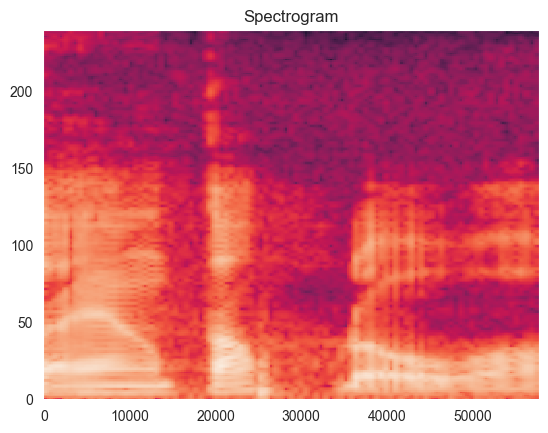

In [75]:
fig, ax = plt.subplots()
plot_spectrogram(new_spectrogram.numpy().reshape(new_spectrogram.shape[1], new_spectrogram.shape[2]), ax)
ax.set(title='Spectrogram')
plt.show()